In [62]:
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import pandas as pd
from scipy.special import expit
from matplotlib import pyplot as plt
import numpy as np
import bw_processing as bwp

In [63]:
def replacement(cf_mass):
    return 5 - cf_mass * (1 + expit(cf_mass * 4 - 5)) + np.random.rand()

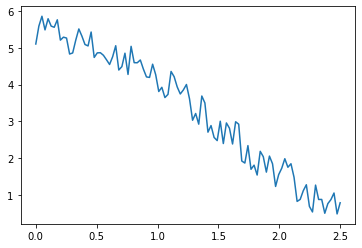

In [64]:
arr = np.linspace(0, 2.5, 100)
plt.plot(arr, [replacement(x) for x in arr])

In [65]:
cf_amounts = np.random.rand(1000) * 2.5
alu_amounts = replacement(cf_amounts)

(array([107.,  84.,  94.,  82.,  54.,  57.,  86.,  88., 156., 192.]),
 array([0.29267982, 0.78913291, 1.28558599, 1.78203907, 2.27849216,
        2.77494524, 3.27139833, 3.76785141, 4.26430449, 4.76075758,
        5.25721066]),
 <BarContainer object of 10 artists>)

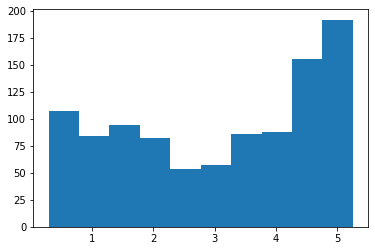

In [66]:
plt.hist(alu_amounts)

In [67]:
bd.projects.set_current("fresh-start")

In [68]:
if "mobility" in bd.databases:
    del bd.databases['mobility']
    
if "biosphere" in bd.databases:
    del bd.databases['biosphere']    

In [69]:
db = bd.Database("mobility")
db.register()

biosphere = bd.Database("biosphere")
biosphere.register()

In [70]:
data = {
    'code': 'bike',
    'name': 'bike production',
    'location': 'NO',
    'unit': 'bike'
}

bike = db.new_activity(**data)
bike.save()

In [71]:
data = {
    'code': 'CF',
    'name': 'carbon fibre',
    'unit': 'kilogram',
    'location': 'CN'
}

cf = db.new_activity(**data)
cf.save()

In [72]:
data = {
    'code': 'Alu',
    'name': 'Aluminium',
    'unit': 'kilogram',
    'location': 'NO'
}

alu = db.new_activity(**data)
alu.save()

In [73]:
ng = db.new_activity(
    name="Nat Gas", 
    code='ng', 
    location='NO', 
    unit='MJ'
)

ng.save()

In [74]:
co2 = biosphere.new_activity(
    name="Carbon Dioxide", 
    code='co2', 
    categories=('air',),
    type='emission',
)

co2.save()

In [75]:
bike.new_exchange(
    amount=2.5, 
    type='technosphere',
    input=cf
).save()

In [76]:
bike.new_exchange(
    amount=0, 
    type='technosphere',
    input=alu,
).save()

In [77]:
cf.new_exchange(
    amount=237.3,  # plus 58 kWh of electricity, in ecoinvent 3.8 
    uncertainty_type=5, 
    minimum=200, 
    maximum=300, 
    type='technosphere',
    input=ng,
).save()

In [78]:
cf.new_exchange(
    amount=26.6, 
    uncertainty_type=5, 
    minimum=26,
    maximum=27.2, 
    type='biosphere',
    input=co2,
).save()

In [79]:
alu.new_exchange(
    amount=8, 
    uncertainty_type=2, 
    loc=8,
    scale=1,
    type='biosphere',
    input=co2,
).save()

In [80]:
ipcc = bd.Method(('IPCC',))
ipcc.write([
    (co2.key, {'amount': 1, 'uncertainty_type': 3, 'loc': 1, 'scale': 0.05}),
])

In [81]:
import bw2calc as bc

What if we only want uncertainty in the characterization step?

We need to modify the datapackage a bit

In [82]:
from bw_processing import load_datapackage
from fs.zipfs import ZipFS

In [83]:
database_dp = load_datapackage(ZipFS(db.filepath_processed()))
method_dp = load_datapackage(ZipFS(ipcc.filepath_processed()))

We can use the datapackages directly, just as before:

In [84]:
array_dp = bwp.create_datapackage()

In [85]:
indices_array = np.array([(cf.id, bike.id), (alu.id, bike.id)], dtype=bwp.INDICES_DTYPE)
indices_array

array([(2651, 2650), (2652, 2650)], dtype=[('row', '<i4'), ('col', '<i4')])

In [86]:
{o.id: o for o in db}

{2653: 'Nat Gas' (MJ, NO, None),
 2650: 'bike production' (bike, NO, None),
 2651: 'carbon fibre' (kilogram, CN, None),
 2652: 'Aluminium' (kilogram, NO, None)}

In [87]:
array_dp.add_persistent_array(
    matrix="technosphere_matrix",
    data_array=np.vstack([cf_amounts, alu_amounts]),
    name="alu replacing CF",
    flip_array=np.array([True, True]),
    indices_array=indices_array,
)

In [88]:
lca = bc.LCA(
    demand={bike.id: 1},
    data_objs=[database_dp, method_dp, array_dp],
    use_distributions=False,
    use_arrays=True,
    seed_override=None
)
lca.lci()
lca.lcia()

In [89]:
pd.DataFrame([
    {
        'score': lca.score, 
        'inv': lca.inventory.sum(), 
        'char': lca.characterization_matrix.sum()
    } for _, _ in zip(lca, range(10))
])

,score,inv,char
0,52.855247,52.855247,1.0
1,65.335662,65.335662,1.0
2,62.304891,62.304891,1.0
3,63.398182,63.398182,1.0
4,67.605964,67.605964,1.0
5,67.641376,67.641376,1.0
6,55.228749,55.228749,1.0
7,60.456818,60.456818,1.0
8,63.696744,63.696744,1.0
9,62.919598,62.919598,1.0
